<em>This notebook contains an excerpt from a study prepared by Radwan Diab, Mahmoud Aslan and Eiad Soufan; Supervised by Suhel Al-Hammoud PhD. </em>

# Improving Network Intrusion Detection using a Denoising Autoencoder with Dropout

This notebook presents an autoencoder based anomaly detection model for intrusion detection, we use the NSL-KDD dataset, this dataset is a benchmark for machine learning based intrusion detection, however , it suffers from several inefficiencies such as class imbalance, where for instance in the NSL-KDD training dataset only 0.04% of the samples belong to the u2r attack type making it severely underrepresented, the case is similar for the r2l and probe attack types whereas the majority of attack records are representing the DDOS attack type, this fact made it difficult for classifiers to detect these underrepresented types resulting in poor accuracy. Another issue is that this dataset is unrealistic, in reality most traffic in a network is benign and only a small percentage might be malicious, while in the NSL-KDD training set for example, attack samples compose 80% of the entire dataset which makes the models trained using this dataset ineffective in real life situations. Out autoencoder based approach attempts to overcome these problems.

## Dependencies 

The notebook uses the following libraries :
- NumPy
- Pandas
- matplotlib
- Keras
- scikit-learn
- TensorFlow or Theano

The following section makes the necessary imports :

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input,Dropout,Dense
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file
%matplotlib inline

Using TensorFlow backend.


# Loading the data
The NSL-KDD dataset is available in a github __[repository](https://github.com/defcom17/NSL_KDD)__, we will be using the following files
- __[KDDTrain+.csv](https://github.com/defcom17/NSL_KDD/blob/master/KDDTrain%2B.csv)__ for training the model.
- __[KDDTest+.csv](https://github.com/defcom17/NSL_KDD/blob/master/KDDTest%2B.csv)__ for testing.

We will use the utility function `get_file` from keras to download the files and we'll read them into a pandas dataframe afterward.

In [2]:


# Downloading training and test sets to local drive
try:
    training_set_path = get_file('KDDTrain%2B.csv', origin='https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv')
except:
    print('Error downloading')
    raise
    

try:
    test_set_path = get_file('KDDTest%2B.csv', origin='https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv')
except:
    print('Error downloading')
    raise
training_df = pd.read_csv(training_set_path, header=None)
testing_df = pd.read_csv(test_set_path, header=None)


Next we'll take a look at the dataframes :

In [3]:
training_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
testing_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


Since the CSV files don't contain a header we'll need to assign column names ourselves.

In [5]:
 columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome',
    'difficulty'
]
training_df.columns = columns
testing_df.columns = columns

Now that we've assigned names to the columns let's take a deeper look into the data.

In [6]:
print("Training set has {} rows.".format(len(training_df)))
print("Testing set has {} rows.".format(len(testing_df)))

Training set has 125973 rows.
Testing set has 22543 rows.


In [7]:
training_outcomes=training_df["outcome"].unique()
testing_outcomes=testing_df["outcome"].unique()
print("The training set has {} possible outcomes \n".format(len(training_outcomes)) )
print(", ".join(training_outcomes)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_outcomes)))
print(", ".join(testing_outcomes)+".")

The training set has 23 possible outcomes 

normal, neptune, warezclient, ipsweep, portsweep, teardrop, nmap, satan, smurf, pod, back, guess_passwd, ftp_write, multihop, rootkit, buffer_overflow, imap, warezmaster, phf, land, loadmodule, spy, perl.

The testing set has 38 possible outcomes 

neptune, normal, saint, mscan, guess_passwd, smurf, apache2, satan, buffer_overflow, back, warezmaster, snmpgetattack, processtable, pod, httptunnel, nmap, ps, snmpguess, ipsweep, mailbomb, portsweep, multihop, named, sendmail, loadmodule, xterm, worm, teardrop, rootkit, xlock, perl, land, xsnoop, sqlattack, ftp_write, imap, udpstorm, phf.


# Preprocessing


## Extracting the labels

As depicted previously the testing set has an additional 15 attack types that are not available in training data hence we will need  more general labels to train the model for the classification task.


The 37 attack types available in the dataset can be clustered into four general attack types

- Denial of service attacks
- Remote to Local attacks
- User to Root
- Probe attacks

Our model will perform binary classification of the data to two classes indicating whether the traffic is normal or an Attack, however we will  use the four attack types to analyze the results and calculate performance metrics for each general attack type.

The next section replaces the current outcome field with a Class field that has one of the following values :
- Normal
- Dos
- R2L
- U2R
- Probe

In [8]:
# A list ot attack names that belong to each general attack type
dos_attacks=["snmpgetattack","back","land","neptune","smurf","teardrop","pod","apache2","udpstorm","processtable","mailbomb"]
r2l_attacks=["snmpguess","worm","httptunnel","named","xlock","xsnoop","sendmail","ftp_write","guess_passwd","imap","multihop","phf","spy","warezclient","warezmaster"]
u2r_attacks=["sqlattack","buffer_overflow","loadmodule","perl","rootkit","xterm","ps"]
probe_attacks=["ipsweep","nmap","portsweep","satan","saint","mscan"]

# Our new labels
classes=["Normal","Dos","R2L","U2R","Probe"]

#Helper function to label samples to 5 classes
def label_attack (row):
    if row["outcome"] in dos_attacks:
        return classes[1]
    if row["outcome"] in r2l_attacks:
        return classes[2]
    if row["outcome"] in u2r_attacks:
        return classes[3]
    if row["outcome"] in probe_attacks:
        return classes[4]
    return classes[0]


#We combine the datasets temporarily to do the labeling 
test_samples_length = len(testing_df)
df=pd.concat([training_df,testing_df])
df["Class"]=df.apply(label_attack,axis=1)


# The old outcome field is dropped since it was replaced with the Class field, the difficulty field will be dropped as well.
df=df.drop("outcome",axis=1)
df=df.drop("difficulty",axis=1)

# we again split the data into training and test sets.
training_df= df.iloc[:-test_samples_length, :]
testing_df= df.iloc[-test_samples_length:,:]


Let's take a look at the new labels 

In [9]:
training_outcomes=training_df["Class"].unique()
testing_outcomes=testing_df["Class"].unique()
print("The training set has {} possible outcomes \n".format(len(training_outcomes)) )
print(", ".join(training_outcomes)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_outcomes)))
print(", ".join(testing_outcomes)+".")

The training set has 5 possible outcomes 

Normal, Dos, R2L, Probe, U2R.

The testing set has 5 possible outcomes 

Dos, Normal, Probe, R2L, U2R.


## Preparing the Features

For continuous features we use the `MinMaxScaler` provided by the scikit-learn library, we only allow the scaler to fit the training set values and then we use it to scale both the training and testing sets. The `minmax_scale_values` helper function does this task.

As for the discrete features we use one hot encoding. The `encode_text` function achieves this.

In [10]:
# Helper function for scaling continous values
def minmax_scale_values(training_df,testing_df, col_name):
    scaler = MinMaxScaler()
    scaler = scaler.fit(training_df[col_name].reshape(-1, 1))
    train_values_standardized = scaler.transform(training_df[col_name].reshape(-1, 1))
    training_df[col_name] = train_values_standardized
    test_values_standardized = scaler.transform(testing_df[col_name].reshape(-1, 1))
    testing_df[col_name] = test_values_standardized
    
    
#Helper function for one hot encoding
def encode_text(training_df,testing_df, name):
    training_set_dummies = pd.get_dummies(training_df[name])
    testing_set_dummies = pd.get_dummies(testing_df[name])
    for x in training_set_dummies.columns:
        dummy_name = "{}_{}".format(name, x)
        training_df[dummy_name] = training_set_dummies[x]
        if x in testing_set_dummies.columns :
            testing_df[dummy_name]=testing_set_dummies[x]
        else :
            testing_df[dummy_name]=np.zeros(len(testing_df))
    training_df.drop(name, axis=1, inplace=True)
    testing_df.drop(name, axis=1, inplace=True)
    
    
sympolic_columns=["protocol_type","service","flag"]
label_column="Class"
for column in df.columns :
    if column in sympolic_columns:
        encode_text(training_df,testing_df,column)
    elif not column == label_column:
        minmax_scale_values(training_df,testing_df, column)

In [11]:
training_df.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
testing_df.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,0.000047,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.000023,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


Next we extract the values from the pandas dataframes as Numpy arrays, where :
- `x` holds the features of the training dataset
- `y` holds the classification of the training dataset to one of the five possible values
- `x_test` holds the features of the testing dataset
- `y_test` holds the classification of the testing dataset to one of the five possible values
- `y0` holds the classification of the training dataset to one of two possible labels, 0 for normal traffic or 1 for an attack
- `y0_test` holds the classification of the testing dataset to one of two possible labels, 0 for normal traffic or 1 for an attack

In [13]:
x,y=training_df,training_df.pop("Class").values
x=x.values
x_test,y_test=testing_df,testing_df.pop("Class").values
x_test=x_test.values
y0=np.ones(len(y),np.int8)
y0[np.where(y==classes[0])]=0
y0_test=np.ones(len(y_test),np.int8)
y0_test[np.where(y_test==classes[0])]=0

In [14]:
x.shape

(125973, 122)

In [15]:
x_test.shape

(22543, 122)

In [16]:
y.shape

(125973,)

In [17]:
y_test.shape

(22543,)

# The Model

In order to avoid the imbalance of the samples representing each attack type in the training data, and to avoid the model’s inability to learn about new attack types by observing existing ones, we present an approach that utilizes autoencoders and reconstruction error to detect anomalies.

## Architecture and Training


In this approach we implemented a sparse autoencoder with dropout on the inputs, it consists of an input layer of 122 neurons due to the fact that the number of features for each sample is 122 followed by a dropout layer and a hidden layer of 8 neuron units so the hidden representation of the autoencoder has a compression ratio of 122/8 forcing it to learn interesting patterns and relations between the features, finally there is an output layer of 122 units, the activation of both the hidden layer and the output layer is the relu function.

The autoencoder was trained to reconstruct its input, in other words it learns the identity function, the model was trained using only the samples labeled “Normal” in the training dataset allowing it to capture the nature of normal behavior, this was accomplished by training the model to minimize the mean squared error between its output and its input.

The regularization constraints enforced over the autoencoder prevent it from simply copying the input to the output and overfitting the data, furthermore the dropout presented on the inputs makes the autoencoder a special case of a denoising autoencoder, this kind of autoencoders is trained to reconstruct the input from a distorted corrupted version of itself, forcing the autoencoder to learn even more properties of the data.

The model is trained for 10 epochs using an Adam optimizer with a batch size of 100, furthermore we held out 10% of the normal training samples to validate the model.

In [18]:
#Buildling and training the model

def getModel():
    inp = Input(shape=(x.shape[1],))
    d1=Dropout(0.5)(inp)
    encoded = Dense(8, activation='relu', activity_regularizer=regularizers.l2(10e-5))(d1)
    decoded = Dense(x.shape[1], activation='relu')(encoded)
    autoencoder = Model(inp, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

autoencoder=getModel()
history=autoencoder.fit(x[np.where(y0==0)],x[np.where(y0==0)],
               epochs=10,
                batch_size=100,
                shuffle=True,
                validation_split=0.1
                       )

Train on 60608 samples, validate on 6735 samples
Epoch 1/10
60608/60608 [==============================] - 1s - loss: 0.0263 - val_loss: 0.0130
Epoch 2/10
60608/60608 [==============================] - 1s - loss: 0.0124 - val_loss: 0.0093
Epoch 3/10
60608/60608 [==============================] - 1s - loss: 0.0103 - val_loss: 0.0079
Epoch 4/10
60608/60608 [==============================] - 1s - loss: 0.0094 - val_loss: 0.0072
Epoch 5/10
60608/60608 [==============================] - 1s - loss: 0.0089 - val_loss: 0.0067
Epoch 6/10
60608/60608 [==============================] - 1s - loss: 0.0086 - val_loss: 0.0063
Epoch 7/10
60608/60608 [==============================] - 1s - loss: 0.0083 - val_loss: 0.0061
Epoch 8/10
60608/60608 [==============================] - 1s - loss: 0.0081 - val_loss: 0.0059
Epoch 9/10
60608/60608 [==============================] - 1s - loss: 0.0080 - val_loss: 0.0058
Epoch 10/10
60608/60608 [==============================] - 1s - loss: 0.0078 - val_loss: 0.0056


## Prediction

The model performs anomaly detection by calculating the reconstruction error of samples, since the model was trained using normal data samples only the reconstruction error of samples that represent attacks should be relatively high compared to the reconstruction error of normal data samples, this intuition allows us to detect attacks by setting a threshold for the reconstruction error, if a data sample has a reconstruction error higher than the preset threshold then the sample is classified as an attack, otherwise it’s classified as normal traffic.


For the choice of a threshold two values can be helpful for guiding the process, the model loss over the training data and over the validation data, we found by experiment that a choice around these values produces acceptable results, for our experiments we use the model loss over the training data as a threshold. 


Due to the nature of this approach it can only be used for 2-Class classification as it is purely for anomaly detection and not classification.

The following section evaluates the performance over the testing dataset, the `calculate_losses` is a helper function that accepts the original features and the predicted features (the autoencoder's output) and returns the reconstruction loss of each data sample, afterwards each data sample is classified according to its reconstruction error and the preset threshold.



In [19]:
# Helper function that calculates the reconstruction loss of each data sample
def calculate_losses(x,preds):
    losses=np.zeros(len(x))
    for i in range(len(x)):
        losses[i]=((preds[i] - x[i]) ** 2).mean(axis=None)
        
    return losses

# We set the threshold equal to the training loss of the autoencoder
threshold=history.history["loss"][-1]

testing_set_predictions=autoencoder.predict(x_test)
test_losses=calculate_losses(x_test,testing_set_predictions)
testing_set_predictions=np.zeros(len(test_losses))
testing_set_predictions[np.where(test_losses>threshold)]=1


## Evaluation
To evaluate the model we calculate the following performance metrics :
- Accuracy
- Recall
- Precision
- F1 Score
- Detection rate for each of the five possible labels

In [20]:
accuracy=accuracy_score(y0_test,testing_set_predictions)
recall=recall_score(y0_test,testing_set_predictions)
precision=precision_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}\n".format(accuracy,recall,precision,f1 ))

#


for class_ in classes:
    print(class_+" Detection Rate : {}".format(len(np.where(np.logical_and(testing_set_predictions==1 , y_test==class_))[0])/len(np.where(y_test==class_)[0])))


Performance over the testing data set 

Accuracy : 0.9032515636783037 , Recall : 0.959167770591444 , Precision : 0.88135471860232 , F1 : 0.918616366282324

Normal Detection Rate : 0.17064881565396497
Dos Detection Rate : 0.9392352016762703
R2L Detection Rate : 0.9785898855666297
U2R Detection Rate : 0.9701492537313433
Probe Detection Rate : 1.0


The results performs well and is stable across many test runs and it outperforms many other approaches including other approaches we attempted as part of our study.

The following section plots the confusion matrix, the `plot_confusion_matrix` helper function was adapted from the __[scikit-learn library documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)__.

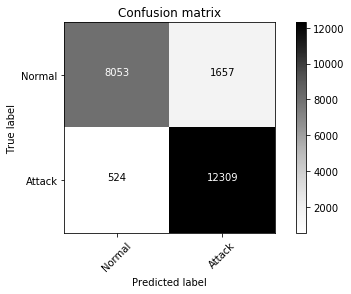

In [21]:
#Plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
c = confusion_matrix(y0_test,testing_set_predictions)
plot_confusion_matrix(c,["Normal","Attack"])


The following violin plot shows the distribution of reconstruction loss values for all data samples in the testing set, it clearly shows that the  loss values of attacks are mostly higher then the threshold value, the opposite is true for normal samples.

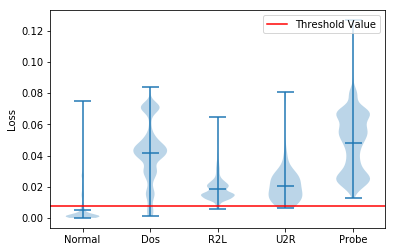

In [22]:
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([test_losses[np.where(y_test==class_)] for class_ in classes],np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=threshold,c='r',label="Threshold Value")
plt.legend();

# Conclusion

In this approach we attempted to overcome the problems that exists in the KDD99 and NSL-KDD datasets, namely the class imbalance issue and the data being unrealistic, by avoiding the attacks data during training, the model was trained only using normal traffic, so it was not affected by the class imbalance of the dataset, in addition the fact that it only uses normal traffic data for training makes it more valuable in real world applications and more viable for use in real networks.

Another strength of this approach is its simplicity, it consist of only a single hidden layer of 8 neurons making it very easy to train and especially suitable for online learning.
During evaluation we avoided human manipulation of the threshold in order to achieve reproducible results without human interference, however in real networks when the system is deployed the network administrator can manually adjust the threshold which allows a tradeoff between sensitivity and specificity according to the network requirements which is a huge advantage over other existing approaches.
In terms of detection rates our approach outperforms every method in the existing literature that we are aware of.

The obvious limitation of our approach is that it can only differentiate between normal and attack traffic, so classifying attacks to the different attack types is not possible, future work can be done to overcome this limitation by building an ensemble of the model alongside others that extend its functionality in order to achieve 5-class classification.